# Generative Adversarial Networks

## Summary

- Introduction
- GAN flavours
- Deep Convolutional GANs
- StyleGANs

## Introduction

### GAN in a nutshell

- First described in [Generative Adversarial Nets
](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) by Goodfellow et al. (2014).
- Simultaneously train two models:
  - One tries to generate realistic data.
  - The other tries to discriminate between real and generated data.
- Each model is trained to best the other.
- [NIPS 2016 Tutorial](https://arxiv.org/abs/1701.00160).


[![GAN overview](images/gan1.png)](https://www.tensorflow.org/tutorials/generative/dcgan)

[![GAN process](images/gan2.png)](https://www.tensorflow.org/tutorials/generative/dcgan)

### Training process

Multiple iterations, each consisting of:

- Phase 1
  - The generator creates images from random noise (typically a Gaussian distribution).
  - Generated images are mixed with real ones.
  - The discriminator is trained to distinguish fake vs. real images.
- Phase 2
  - Another batch of images is produced by the generator.
  - The generator is trained so that the discriminator classifies these generated images as real.

### Example: generating fashion images with a basic GAN

(Heavily inspired by Chapter 17 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

#### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [21]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Reshape,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    LeakyReLU,
    Dropout
)
from tensorflow.keras.datasets import fashion_mnist

TensorFlow version: 2.3.1
Keras version: 2.4.0


#### Data loading

In [4]:
# Load training inputs from the Fashion-MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Change pixel values from (0, 255) to (0, 1)
x_train = train_images.astype("float32") / 255

print(f"x_train: {x_train.shape}")

x_train: (60000, 28, 28)


In [5]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

#### Model definition

In [6]:
# Input dimensionality for generator
codings_size = 30

generator = Sequential(
    [
        Dense(100, activation="selu", input_shape=(codings_size,)),
        Dense(150, activation="selu"),
        Dense(28 * 28, activation="sigmoid"),
        Reshape((28, 28)),
    ],
    name="generator"
)
discriminator = Sequential(
    [
        Flatten(input_shape=(28, 28)),
        Dense(150, activation="selu"),
        Dense(100, activation="selu"),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator"
)

In [7]:
gan = Sequential([generator, discriminator])

# Print GAN model summary
gan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28)            136634    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 132951    
Total params: 269,585
Trainable params: 269,585
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [8]:
# The generator is trained through the GAN model: no need to compile it

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# The trainable attribute is taken into account only when compiling a model
# Discriminator weights will be updated only when it will be trained on its own
# They will be frozen when the whole GAN model will be trained
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch [{epoch+1}/{n_epochs}]...")
        for x_batch in dataset:
            # Phase 1 - training the discriminator
            noise = tf.random.normal(shape=(batch_size, codings_size))
            generated_images = generator(noise)
            # Gather an equal number of generated (y=0) and real (y=1) images
            x_discr = tf.concat([generated_images, x_batch], axis=0)
            y_discr = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            # https://stackoverflow.com/a/49100617
            discriminator.train_on_batch(x_discr, y_discr)
            
            # Phase 2 - training the generator
            noise = tf.random.normal(shape=(batch_size, codings_size))
            # Generated images should be labeled "real" by the discriminator
            y_gen = tf.constant([[1.0]] * batch_size)
            # Update only the generator weights (see above)
            gan.train_on_batch(noise, y_gen)
    print("Training complete!")

In [10]:
batch_size = 32

# Load images in batches
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Train the GAN model
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch [1/1]...
Training complete!


#### Generating new images

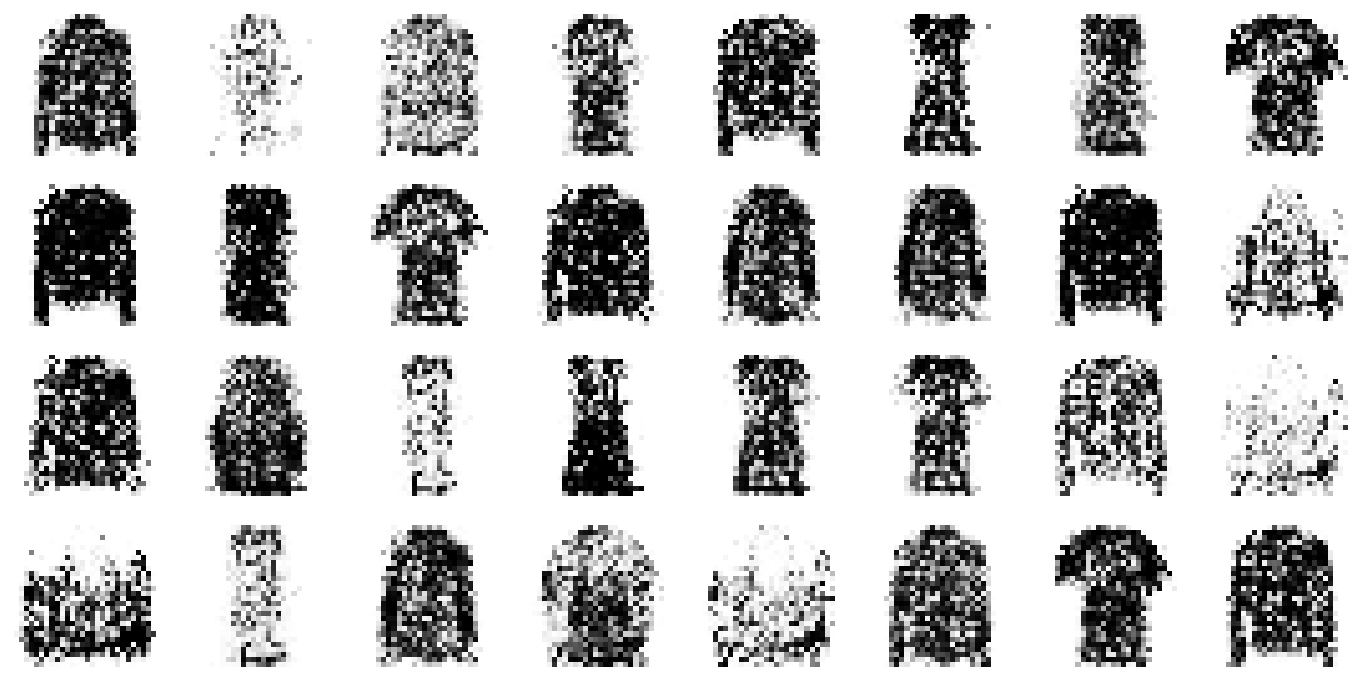

In [11]:
noise = tf.random.normal(shape=(batch_size, codings_size))
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

### GAN specificities and gotchas

- A GAN is a *dynamic system* that evolves at each training step.
- Interestingly, the generator never sees images froms the training set directly: all it gets are the gradients coming back from the discriminator.
- Training can be tricky with several pitfalls: noisy generated data, vanishing gradients, lack of diversity in generated data, domination of one side...
- GAN convergence theory is an active area of research.
- [GAN Open Questions](https://distill.pub/2019/gan-open-problems/).

## GAN flavours

### The GAN landscape

[![GAN flavours](images/gan_flavours.png)](https://blog.floydhub.com/gans-story-so-far/)

### GAN progress on face generation

[![GAN progress from 2014 to 2018](images/gan_2014_2018.jpg)](https://twitter.com/goodfellow_ian/status/1084973596236144640)

### GAN use cases: not just images!

- Writing a novel "in the style of an author".
- [Generating music](https://arxiv.org/abs/1805.07848) ([samples](https://www.youtube.com/watch?v=vdxCqNWTpUs)).
- Generating realistic passwords for hackers.
- Generating videos ([example](https://www.youtube.com/watch?time_continue=3&v=ab64TWzWn40&feature=emb_logo)).
- [Generating video game levels](https://arxiv.org/abs/1910.01603).
- ...

## Deep Convolutional GANs

### Architecture

A few months after the original GAN paper came out, a team succeeded in building GANs based on deeper convolutional models, or DCGANs ([paper](https://arxiv.org/abs/1511.06434)).

General rules for implemeting DCGANs are:

- Replace pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).
- Add batch normalization.
- Use ReLU in the generator except for the output layer, which should use tanh.
- Use leaky ReLU in the discriminator.

#### The leaky ReLU activation function

Leaky version of a Rectified Linear Unit. It allows a small gradient when the unit is not active to prevent the "dying ReLU" problem (neurons always outputting zero).

$$LeakyReLU_\alpha(z) = max(\alpha z,z)$$

![Leaky ReLU](images/leaky_relu.png)

### Example: generating fashion images with a DCGAN

(Heavily inspired by Chapter 17 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

#### Generator definition

In [35]:
# Input dimensionality for generator
codings_size = 100

dcgan_generator = Sequential(
    [
        Dense(7 * 7 * 128, input_shape=(codings_size,)),
        Reshape((7, 7, 128)),
        BatchNormalization(),
        Conv2DTranspose(
            64, kernel_size=5, strides=2, padding="same", activation="selu"
        ),
        BatchNormalization(),
        Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)

In [36]:
dcgan_generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
_________________________________________________

#### Discriminator definition

In [37]:
dcgan_discriminator = Sequential(
    [
        Conv2D(
            64,
            kernel_size=5,
            strides=2,
            padding="same",
            activation=LeakyReLU(0.2),
            input_shape=(28, 28, 1),
        ),
        Dropout(0.4),
        Conv2D(
            128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2)
        ),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [38]:
dcgan_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_______________________________________________

#### Model definition

In [40]:
dcgan = Sequential([dcgan_generator, dcgan_discriminator])

dcgan.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28, 1)         840705    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 1,053,186
Non-trainable params: 384
_________________________________________________________________


#### Model training

In [41]:
# The generator is trained through the GAN model: no need to compile it

dcgan_discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# The trainable attribute is taken into account only when compiling a model
# Discriminator weights will be updated only when it will be trained on its own
# They will be frozen when the whole GAN model will be trained
dcgan_discriminator.trainable = False

dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [43]:
# Reshape and rescale input into a 4D tensor with values between -1 and 1
# Needed because tanh outputs are in this range
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
print(f"x_train_dcgan: {x_train_dcgan.shape}")

x_train_dcgan: (60000, 28, 28, 1)


In [45]:
batch_size = 32

# Load images in batches
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Train the DCGAN model
train_gan(dcgan, dataset, batch_size, codings_size, n_epochs=5)

Epoch [1/5]...
Epoch [2/5]...
Epoch [3/5]...
Epoch [4/5]...
Epoch [5/5]...
Training complete!


#### Generating new images

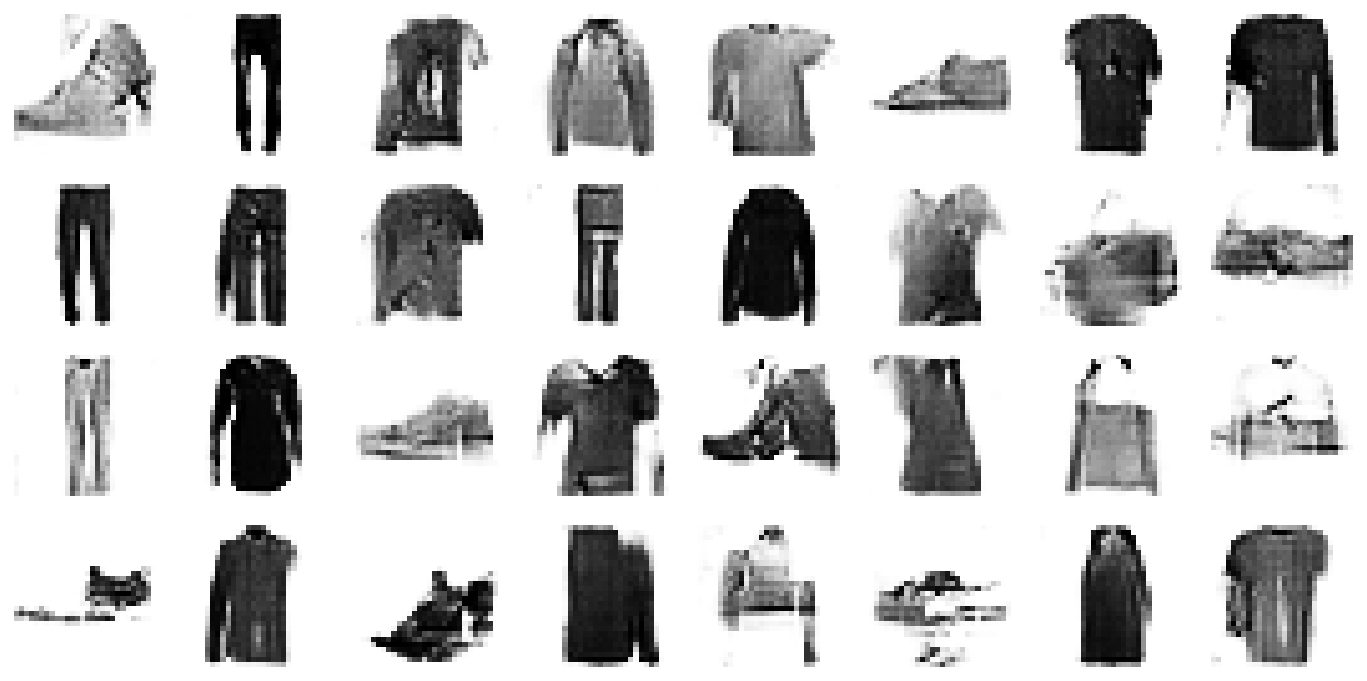

In [46]:
noise = tf.random.normal(shape=(batch_size, codings_size))
generated_images = dcgan_generator(noise)
plot_multiple_images(generated_images, 8)

## StyleGANs